# Setup

Clone GitHub [repository](https://github.com/ultralytics/yolov5), install [dependencies](https://github.com/ultralytics/yolov5/blob/master/requirements.txt) and check PyTorch and GPU.

In [ ]:
import torch
import utils
display = utils.notebook_init()  # checks

# 1. Detect

`detect.py` runs YOLOv5 inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases), and saving results to `runs/detect`. Example inference sources are:

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image
                          vid.mp4  # video
                          screen  # screenshot
                          path/  # directory
                         'path/*.jpg'  # glob
                         'https://youtu.be/LNwODJXcvt4'  # YouTube
                         'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

### Detect Unquantized

In [ ]:
!python3 detect.py --cfg models/lpyolo.yaml --weights experiment_models/lpyolo.pt --img 640 --conf 0.25 --source data/images/zidane.jpg

### Detect Quantized

In [ ]:
!python3 detect.py --cfg models/lpyolo_quant.yaml --weights experiment_models/lpyolo_quant.pt --img 640 --conf 0.25 --source data/images/zidane.jpg

# 2. Validate
Validate a model's accuracy on the [COCO](https://cocodataset.org/#home) dataset's `val` or `test` splits. Models are downloaded automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases). To show results by class use the `--verbose` flag.

### Validate Unquantized

In [ ]:
!python3 val.py --weights experiment_models/lpyolo.pt --data VOC.yaml --img 640 --half

### Validate Quantized

In [ ]:
!python3 val.py --weights experiment_models/lpyolo_W4A4_test.pt --data VOC.yaml --img 640 --half

# 3. Train

### Train Unquantized

In [ ]:
!python3 train.py --img 640 --batch 64 --epochs 300 --data VOC.yaml --weights '' --cache --cfg models/lpyolo.yaml --classes 20 --optimizer Adam

### Train Quantized (QAT)

In [ ]:
!python3 train.py --img 640 --batch 32 --epochs 50 --data VOC.yaml --weights experiment_models/lpyolo.pt --cache --cfg models/lpyolo_quant.yaml --classes 20 --optimizer Adam

# Inference Pretrained Model

YOLOv5 🚀 v7.0-262-gbcf7109c Python-3.10.12 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 10007MiB)


                 from  n    params  module                                  arguments                     
  0                -1  1       232  models.common.Conv                      [3, 8, 3, 1]                  
  1                -1  1         0  torch.nn.modules.pooling.MaxPool2d      [2, 2, 0]                     
  2                -1  1       592  models.common.Conv                      [8, 8, 3, 1]                  
  3                -1  1         0  torch.nn.modules.pooling.MaxPool2d      [2, 2, 0]                     
  4                -1  1      1184  models.common.Conv                      [8, 16, 3, 1]                 
  5                -1  1         0  torch.nn.modules.pooling.MaxPool2d      [2, 2, 0]                     
  6                -1  1      4672  models.common.Conv                      [16, 32, 3, 1]                
  7                -1  1         0  to

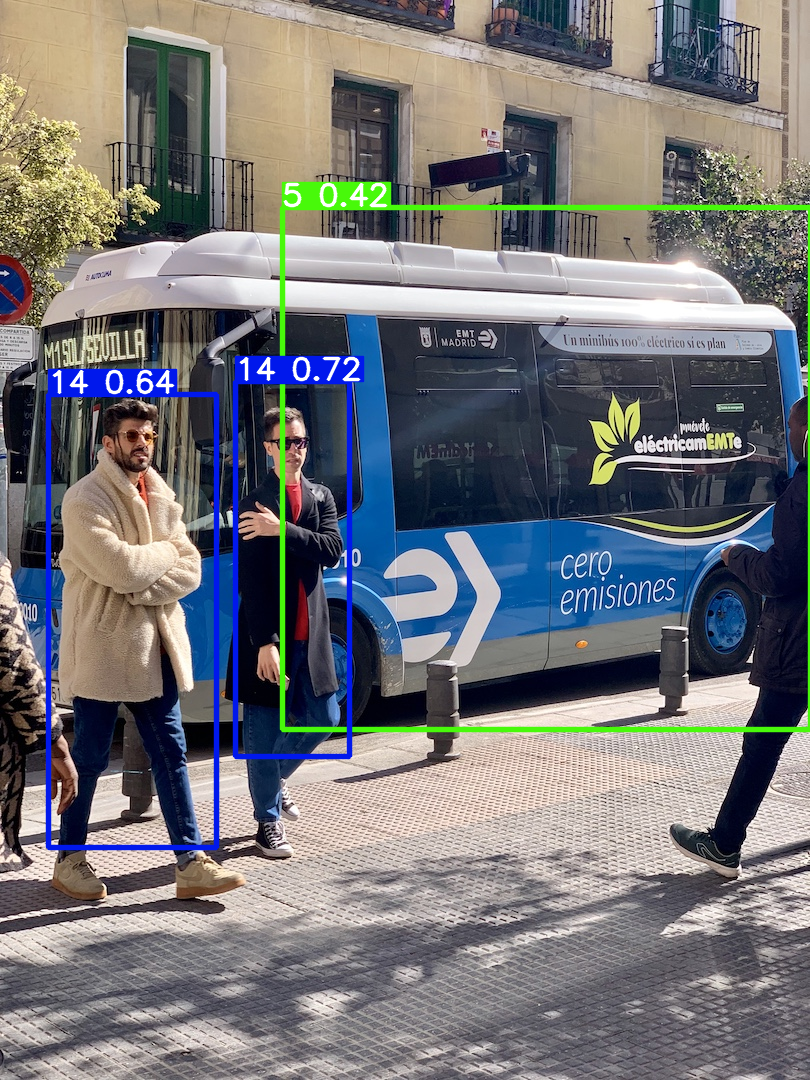

In [6]:
import torch

model_pre = torch.hub.load('.',
                       'custom',
                       'experiment_models/lpyolo.pt',
                       source='local',
                       classes = 20,
                       cfg = "models/lpyolo.yaml",
                       force_reload=True
                      )

im = 'https://ultralytics.com/images/bus.jpg'  # file, Path, PIL.Image, OpenCV, nparray, list
results = model_pre(im)  # inference
results.show()  # or .show(), .save(), .crop(), .pandas(), etc.

# Inference Quantized Model (QAT)

In [ ]:
# YOLOv5 PyTorch HUB Inference (DetectionModels only)
import torch

model_q = torch.hub.load('.',
                       'custom',
                       'experiment_models/lpyolo_W4A4_test.pt',
                       source='local',
                       classes = 20,
                       force_reload=True,
                       cfg = "models/lpyolo_quant.yaml",
                      )

im = 'https://ultralytics.com/images/bus.jpg'  # file, Path, PIL.Image, OpenCV, nparray, list
results = model_q(im)  # inference
results.show()  # or .show(), .save(), .crop(), .pandas(), etc.

## Save Model

In [ ]:
from brevitas.export import export_brevitas_onnx
import torch

IN_CH = 384
OUT_CH = 640
BATCH_SIZE = 1

path = 'experiment_models/lpyoloW4A4_test_quant.onnx'
inp = torch.randn(BATCH_SIZE,3, IN_CH, OUT_CH).cuda()

detection_model = model_q.model.model
detection_model.cuda()
detection_model.eval()

exported_model = export_brevitas_onnx(detection_model, inp, path)

# Visualizing Quantized Weights

In [ ]:
model_q.model.model.model[0].conv.weight

In [ ]:
model_q.model.model.model[0].conv.int_weight()

# Clean Coco Data

In [ ]:
import os

def count_files_in_directory(directory_path):
    # Get the list of files in the directory
    files = os.listdir(directory_path)

    # Count the number of files
    file_count = len(files)

    return file_count


train_img_path = "../datasets/coco128/images/train2017"  
train_label_path = "../datasets/coco128/labels/train2017" 
train_img_dir = os.listdir(train_img_path)
train_label_dir = os.listdir(train_label_path)

val_img_path = "../datasets/coco128/images/val2017"  
val_label_path = "../datasets/coco128/labels/val2017" 
val_img_dir = os.listdir(val_img_path)
val_label_dir = os.listdir(val_label_path)

In [ ]:
train_img_len = count_files_in_directory(train_img_path)
train_label_len = count_files_in_directory(train_label_path)

val_img_len = count_files_in_directory(val_img_path)
val_label_len = count_files_in_directory(val_label_path)

print(train_img_len, train_label_len)
print(val_img_len, val_label_len)

train_img_files = [img_path.replace(".jpg",".txt") for img_path in train_img_dir]

train_imgs_to_delete = list(set(train_img_files) ^ set(train_label_dir))
train_imgs_to_delete = [img_path.replace(".txt",".jpg") for img_path in train_imgs_to_delete]

for train_img_to_delete in train_imgs_to_delete:
    path = train_img_path + "/" + train_img_to_delete
    if os.path.exists(path):
        os.remove(path)
    
print(len(os.listdir(train_img_path)))

val_img_files = [img_path.replace(".jpg",".txt") for img_path in val_img_dir]

val_imgs_to_delete = list(set(val_img_files) ^ set(val_label_dir))
val_imgs_to_delete = [img_path.replace(".txt",".jpg") for img_path in val_imgs_to_delete]

for val_img_to_delete in val_imgs_to_delete:
    path = val_img_path + "/" + val_img_to_delete
    if os.path.exists(path):
        os.remove(path)
    
print(len(os.listdir(val_img_path)))

In [ ]:
import cv2
from matplotlib import pyplot as plt

idx = 2

image_path = val_img_dir[idx]
print(image_path)
print(train_img_path)

img = cv2.imread(val_img_path + "/" + image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(380,640))

plt.imshow(img)
plt.show()

In [ ]:
label_path = val_label_path + "/000000177934.txt"
with open(label_path, 'r') as file:
    # Read the content of the file
    file_content = file.read()

    # Print the content
    print(file_content)